# Задание 2.1 - Нейронные сети

В этом задании вы реализуете и натренируете настоящую нейроную сеть своими руками!

В некотором смысле это будет расширением прошлого задания - нам нужно просто составить несколько линейных классификаторов вместе!

<img src="https://i.redd.it/n9fgba8b0qr01.png" alt="Stack_more_layers" width="400px"/>

In [69]:
import importlib

import math
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

%matplotlib inline

# %load_ext autoreload
# %autoreload 2

In [79]:
import dataset
import gradient_check
import layers
import model
import trainer
import optim
import metrics


# from dataset import load_svhn, random_split_train_val
# from gradient_check import check_layer_gradient, check_layer_param_gradient, check_model_gradient
# from layers import FullyConnectedLayer, ReLULayer
# from model import TwoLayerNet
# from trainer import Trainer, Dataset
# from optim import SGD, MomentumSGD
# from metrics import multiclass_accuracy

# Загружаем данные

И разделяем их на training и validation.

In [4]:
def prepare_for_neural_network(train_X, test_X):
    train_flat = train_X.reshape(train_X.shape[0], -1).astype(np.float) / 255.0
    test_flat = test_X.reshape(test_X.shape[0], -1).astype(np.float) / 255.0
    
    # Subtract mean
    mean_image = np.mean(train_flat, axis = 0)
    train_flat -= mean_image
    test_flat -= mean_image
    
    return train_flat, test_flat
    
train_X, train_y, test_X, test_y = dataset.load_svhn("data", max_train=10000, max_test=1000)    
train_X, test_X = prepare_for_neural_network(train_X, test_X)
# Split train into train and val
train_X, train_y, val_X, val_y = dataset.random_split_train_val(train_X, train_y, num_val = 1000)

# Как всегда, начинаем с кирпичиков

Мы будем реализовывать необходимые нам слои по очереди. Каждый слой должен реализовать:
- прямой проход (forward pass), который генерирует выход слоя по входу и запоминает необходимые данные
- обратный проход (backward pass), который получает градиент по выходу слоя и вычисляет градиент по входу и по параметрам

Начнем с ReLU, у которого параметров нет.

In [24]:
a = np.array([[1,2,3], [4,5,6]])
b = np.array([1,1,1])
a + b

array([[2, 3, 4],
       [5, 6, 7]])

In [20]:
# importlib.reload(layers)
# importlib.reload(gradient_check)

# Implement ReLULayer layer in layers.py
# Note: you'll need to copy implementation of the gradient_check function from the previous assignment

X = np.array([[1,-2,3],
              [-1, 2, 0.1]])

assert gradient_check.check_layer_gradient(layers.ReLULayer(), X)

Gradient check passed!


А теперь реализуем полносвязный слой (fully connected layer), у которого будет два массива параметров: W (weights) и B (bias).

Все параметры наши слои будут использовать для параметров специальный класс `Param`, в котором будут храниться значения параметров и градиенты этих параметров, вычисляемые во время обратного прохода.

Это даст возможность аккумулировать (суммировать) градиенты из разных частей функции потерь, например, из cross-entropy loss и regularization loss.

In [28]:
# importlib.reload(layers)
# importlib.reload(gradient_check)

# Implement FullyConnected layer forward and backward methods
assert gradient_check.check_layer_gradient(layers.FullyConnectedLayer(3, 4), X)

# Implement storing gradients for W and B
assert gradient_check.check_layer_param_gradient(layers.FullyConnectedLayer(3, 4), X, 'W')
assert gradient_check.check_layer_param_gradient(layers.FullyConnectedLayer(3, 4), X, 'B')

Gradient check passed!
Gradient check passed!
Gradient check passed!


## Создаем нейронную сеть

Теперь мы реализуем простейшую нейронную сеть с двумя полносвязным слоями и нелинейностью ReLU. Реализуйте функцию `compute_loss_and_gradients`, она должна запустить прямой и обратный проход через оба слоя для вычисления градиентов.

Не забудьте реализовать очистку градиентов в начале функции.

In [36]:
# importlib.reload(model)
# importlib.reload(layers)
# importlib.reload(gradient_check)

# In model.py, implement compute_loss_and_gradients function
nn = model.TwoLayerNet(n_input=train_X.shape[1], n_output=10, hidden_layer_size=3, reg=0)
loss = nn.compute_loss_and_gradients(train_X[:2], train_y[:2])

# Now implement backward pass and aggregate all of the params
gradient_check.check_model_gradient(nn, train_X[:2], train_y[:2])

Checking gradient for 0_W
Gradient check passed!
Checking gradient for 0_B
Gradient check passed!
Checking gradient for 2_W
Gradient check passed!
Checking gradient for 2_B
Gradient check passed!


True

Теперь добавьте к модели регуляризацию - она должна прибавляться к loss и делать свой вклад в градиенты.

In [64]:
# importlib.reload(model)
# importlib.reload(layers)
# importlib.reload(gradient_check)

# Now implement L2 regularization in the forward and backward pass
nn_with_reg = model.TwoLayerNet(n_input=train_X.shape[1], n_output =10, hidden_layer_size=3, reg=1e1)
loss_with_reg = nn_with_reg.compute_loss_and_gradients(train_X[:2], train_y[:2])

assert loss_with_reg > loss and not np.isclose(loss_with_reg, loss), \
    "Loss with regularization (%2.4f) should be higher than without it (%2.4f)!" % (loss, loss_with_reg)

gradient_check.check_model_gradient(nn_with_reg, train_X[:2], train_y[:2])

Checking gradient for 0_W
Gradient check passed!
Checking gradient for 0_B
Gradient check passed!
Checking gradient for 2_W
Gradient check passed!
Checking gradient for 2_B
Gradient check passed!


True

Также реализуем функцию предсказания (вычисления значения) модели на новых данных.

Какое значение точности мы ожидаем увидеть до начала тренировки?

In [65]:
# importlib.reload(metrics)

# Finally, implement predict function!
# What would be the value we expect?
metrics.multiclass_accuracy(nn_with_reg.predict(train_X[:30]), train_y[:30]) 

0.1

# Допишем код для процесса тренировки

Если все реализовано корректно, значение функции ошибки должно уменьшаться с каждой эпохой, пусть и медленно. Не беспокойтесь пока про validation accuracy.

In [61]:
# importlib.reload(model)
# importlib.reload(trainer)
# importlib.reload(layers)
# importlib.reload(gradient_check)

nn = model.TwoLayerNet(n_input=train_X.shape[1], n_output=10, hidden_layer_size=100, reg=1e1)
dataset = trainer.Dataset(train_X, train_y, val_X, val_y)
coach = trainer.Trainer(nn, dataset, optim.SGD(), learning_rate=1e-2)

# Implement missing pieces in Trainer.fit function
# You should expect loss to go down every epoch, even if it's slow
loss_history, train_history, val_history = coach.fit()

Loss: 2.302397, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.302413, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.302501, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.302320, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.302424, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.302483, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.302622, Train accuracy: 0.148222, val accuracy: 0.140000
Loss: 2.302511, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.302463, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.302548, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.302555, Train accuracy: 0.148222, val accuracy: 0.140000
Loss: 2.302588, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.302482, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.302539, Train accuracy: 0.093111, val accuracy: 0.090000
Loss: 2.302533, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.302574, Train acc

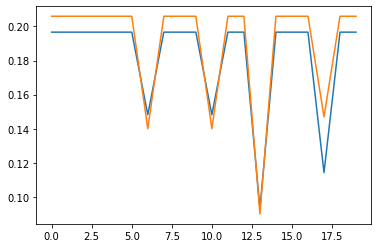

In [63]:
plt.plot(train_history)
plt.plot(val_history);

# Улучшаем процесс тренировки

Мы реализуем несколько ключевых оптимизаций, необходимых для тренировки современных нейросетей.

## Уменьшение скорости обучения (learning rate decay)

Одна из необходимых оптимизаций во время тренировки нейронных сетей - постепенное уменьшение скорости обучения по мере тренировки.

Один из стандартных методов - уменьшение скорости обучения (learning rate) каждые N эпох на коэффициент d (часто называемый decay). Значения N и d, как всегда, являются гиперпараметрами и должны подбираться на основе эффективности на проверочных данных (validation data). 

В нашем случае N будет равным 1.

In [71]:
# importlib.reload(trainer)

# Implement learning rate decay inside Trainer.fit method
# Decay should happen once per epoch

nn = model.TwoLayerNet(n_input=train_X.shape[1], n_output=10, hidden_layer_size=100, reg=1e-1)
dataset = trainer.Dataset(train_X, train_y, val_X, val_y)
coach = trainer.Trainer(nn, dataset, optim.SGD(), learning_rate_decay=0.99)

initial_learning_rate = coach.learning_rate
loss_history, train_history, val_history = coach.fit()

assert coach.learning_rate < initial_learning_rate, "Learning rate should've been reduced"
assert coach.learning_rate > 0.5*initial_learning_rate, "Learning rate shouldn't've been reduced that much!"

Loss: 2.303586, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.293592, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.304204, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.251843, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.288600, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.278663, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.318597, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.228121, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.223722, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.276842, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.327759, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.287617, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.236164, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.203622, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.332110, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.266727, Train acc

# Накопление импульса (Momentum SGD)

Другой большой класс оптимизаций - использование более эффективных методов градиентного спуска. Мы реализуем один из них - накопление импульса (Momentum SGD).

Этот метод хранит скорость движения, использует градиент для ее изменения на каждом шаге, и изменяет веса пропорционально значению скорости.
(Физическая аналогия: Вместо скорости градиенты теперь будут задавать ускорение, но будет присутствовать сила трения.)

```
velocity = momentum * velocity - learning_rate * gradient 
w = w + velocity
```

`momentum` здесь коэффициент затухания, который тоже является гиперпараметром (к счастью, для него часто есть хорошее значение по умолчанию, типичный диапазон -- 0.8-0.99).

Несколько полезных ссылок, где метод разбирается более подробно:  
http://cs231n.github.io/neural-networks-3/#sgd  
https://distill.pub/2017/momentum/

In [74]:
# importlib.reload(trainer)
# importlib.reload(optim)

# Implement MomentumSGD.update function in optim.py

nn = model.TwoLayerNet(n_input=train_X.shape[1], n_output=10, hidden_layer_size=100, reg=1e-1)
dataset = trainer.Dataset(train_X, train_y, val_X, val_y)
coach = trainer.Trainer(nn, dataset, optim.MomentumSGD(), learning_rate=1e-4, learning_rate_decay=0.99)

# You should see even better results than before!
loss_history, train_history, val_history = coach.fit()

Loss: 2.327589, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.324036, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.317725, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.313724, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.316798, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.313802, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.304926, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.303641, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.299772, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.305861, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.303467, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.300830, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.304335, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.300111, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.300842, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.304221, Train acc

# Ну что, давайте уже тренировать сеть!

## Последний тест - переобучимся (overfit) на маленьком наборе данных

Хороший способ проверить, все ли реализовано корректно - переобучить сеть на маленьком наборе данных.  
Наша модель обладает достаточной мощностью, чтобы приблизить маленький набор данных идеально, поэтому мы ожидаем, что на нем мы быстро дойдем до 100% точности на тренировочном наборе. 

Если этого не происходит, то где-то была допущена ошибка!

In [76]:
data_size = 15
nn = model.TwoLayerNet(n_input=train_X.shape[1], n_output=10, hidden_layer_size=100, reg=1e-1)
dataset = trainer.Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])
coach = trainer.Trainer(nn, dataset, optim.SGD(), learning_rate=1e-1, num_epochs=150, batch_size=5)

# You should expect this to reach 1.0 training accuracy 
loss_history, train_history, val_history = coach.fit()

Loss: 2.331183, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.330963, Train accuracy: 0.333333, val accuracy: 0.066667
Loss: 2.312516, Train accuracy: 0.333333, val accuracy: 0.066667
Loss: 2.323351, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.315293, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.283174, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.300711, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.303305, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.284461, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.104304, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.349776, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.212800, Train accuracy: 0.333333, val accuracy: 0.000000
Loss: 1.802621, Train accuracy: 0.333333, val accuracy: 0.000000
Loss: 2.106296, Train accuracy: 0.333333, val accuracy: 0.000000
Loss: 1.544965, Train accuracy: 0.333333, val accuracy: 0.000000
Loss: 1.879828, Train acc

Loss: 1.131232, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.138804, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.519260, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.092240, Train accuracy: 1.000000, val accuracy: 0.000000


Теперь найдем гипепараметры, для которых этот процесс сходится быстрее.
Если все реализовано корректно, то существуют параметры, при которых процесс сходится в **20** эпох или еще быстрее.
Найдите их!

In [105]:
# Now, tweak some hyper parameters and make it train to 1.0 accuracy in 20 epochs or less

nn = model.TwoLayerNet(n_input=train_X.shape[1], n_output=10, hidden_layer_size=100, reg=1e-4)
dataset = trainer.Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])

# Change any hyperparamers or optimizators to reach training accuracy in 20 epochs
coach = trainer.Trainer(nn, dataset, optim.MomentumSGD(), learning_rate=1e-1, num_epochs=20, batch_size=5)

loss_history, train_history, val_history = coach.fit()

Loss: 2.307946, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.280654, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.249790, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.044726, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.794847, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.582240, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 1.734707, Train accuracy: 0.466667, val accuracy: 0.066667
Loss: 1.491432, Train accuracy: 0.466667, val accuracy: 0.133333
Loss: 1.662866, Train accuracy: 0.666667, val accuracy: 0.000000
Loss: 1.279243, Train accuracy: 0.733333, val accuracy: 0.000000
Loss: 1.204057, Train accuracy: 0.733333, val accuracy: 0.133333
Loss: 0.430359, Train accuracy: 0.866667, val accuracy: 0.066667
Loss: 0.557082, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 0.082204, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 0.439251, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.075063, Train acc

# Итак, основное мероприятие!

Натренируйте лучшую нейросеть! Можно добавлять и изменять параметры, менять количество нейронов в слоях сети и как угодно экспериментировать. 

Добейтесь точности лучше **60%** на validation set.

In [ ]:
# Let's train the best one-hidden-layer network we can

learning_rates = 1e-4
reg_strength = 1e-3
learning_rate_decay = 0.999
hidden_layer_size = 128
num_epochs = 200
batch_size = 64

best_classifier = None
best_val_accuracy = None

loss_history = []
train_history = []
val_history = []

# TODO find the best hyperparameters to train the network
# Don't hesitate to add new values to the arrays above, perform experiments, use any tricks you want
# You should expect to get to at least 40% of valudation accuracy
# Save loss/train/history of the best classifier to the variables above

print('best validation accuracy achieved: %f' % best_val_accuracy)

In [ ]:
plt.figure(figsize=(15, 7))
plt.subplot(211)
plt.title("Loss")
plt.plot(loss_history)
plt.subplot(212)
plt.title("Train/validation accuracy")
plt.plot(train_history)
plt.plot(val_history)

# Как обычно, посмотрим, как наша лучшая модель работает на тестовых данных

In [ ]:
test_pred = best_classifier.predict(test_X)
test_accuracy = multiclass_accuracy(test_pred, test_y)
print('Neural net test set accuracy: %f' % (test_accuracy, ))